In [1]:
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/main/brain_tumor_dataset.py --output brain_tumor_dataset.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/cnn-classifier-v2/classification_models2.py --output classification_models2.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/main/trainer.py --output trainer.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   640  100   640    0     0   3200      0 --:--:-- --:--:-- --:--:--  3184
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3952  100  3952    0     0  18641      0 --:--:-- --:--:-- --:--:-- 19000
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4358  100  4358    0     0  23945      0 --:--:-- --:--:-- --:--:-- 23945


## Import modules

In [21]:
import h5py                                           # Read .Mat Files
import random                                         # Get random integers
import pandas as pd                                   # Read CSV
import numpy as np                                    # Transform and save arrays
from skimage.draw import polygon                      # Create images from points

import torch                                          # Framework
from torch import optim                               # optim: Adam, SDG
from torch import nn

from torch.utils import data                          # Data
from torchvision import transforms                    # Transform dataset images

import matplotlib.pyplot as plt                       # Visualize images and more

from brain_tumor_dataset import BrainTumorDataset     # Dataset
import classification_models2 as models                # Module for models
from trainer import Trainer, ModelCheckpoint          # Trainer Class

## Preprocessing Dataset | (from .mat to .npy)

Download and unzip dataset

In [3]:
!curl https://figshare.com/ndownloader/articles/1512427/versions/5 --output data.zip
!mkdir tmp_dataset
!mkdir dataset
!unzip data.zip -d ./tmp_dataset
!for file in ./tmp_dataset/*.zip; do unzip $file -d ./tmp_dataset/; done
!rm ./tmp_dataset/*.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  838M  100  838M    0     0  67.4M      0  0:00:12  0:00:12 --:--:-- 45.2M
Archive:  data.zip
 extracting: ./tmp_dataset/brainTumorDataPublic_1-766.zip  
 extracting: ./tmp_dataset/brainTumorDataPublic_1533-2298.zip  
 extracting: ./tmp_dataset/brainTumorDataPublic_767-1532.zip  
 extracting: ./tmp_dataset/brainTumorDataPublic_2299-3064.zip  
 extracting: ./tmp_dataset/cvind.mat  
 extracting: ./tmp_dataset/README.txt  
Archive:  ./tmp_dataset/brainTumorDataPublic_1533-2298.zip
  inflating: ./tmp_dataset/1533.mat  
  inflating: ./tmp_dataset/1534.mat  
  inflating: ./tmp_dataset/1535.mat  
  inflating: ./tmp_dataset/1536.mat  
  inflating: ./tmp_dataset/1537.mat  
  inflating: ./tmp_dataset/1538.mat  
  inflating: ./tmp_dataset/1539.mat  
  inflating: ./tmp_dataset/1540.mat  
  inflating: ./tmp_dataset/1541.mat  
  inflating: 

Convert .mat to .npy

In [4]:
data_tmp = {'image':[], 'label':[]}
index = 0
for i in range(3064):
  with h5py.File(f"tmp_dataset/{i+1}.mat", 'r') as f:
    img = np.array(f.get('cjdata/image'), dtype=np.float32)
    if img.shape == (512, 512):
      border = np.array(f.get('cjdata/tumorBorder')).reshape((-1, 2))
      name = f"{index+1}.npy"
      img = img / img.max()

      mask = np.zeros_like(img, dtype=np.float32)
      rr, cc = polygon(border[:,0], border[:,1], img.shape)
      mask[rr,cc] = 1.0

      result = np.stack([img, mask], axis=2)

      np.save("./dataset/"+name, result)
      data_tmp['image'].append(name)
      data_tmp['label'].append(np.array(f.get('cjdata/label'), dtype=np.int64).item()-1)
      index += 1

Save labels in a CSV file

In [5]:
df = pd.DataFrame(data_tmp)
df.to_csv('./dataset/data.csv', index=False)
df.head()
del df, data_tmp

Remove MAT files

In [6]:
!rm -rf tmp_dataset

## Functions Tools

In [7]:
def split_dataset(dataset, train_size=0.8):
  n = len(dataset)
  n_train = int(n*train_size)
  n_val = n - n_train
  train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])
  return train_dataset, val_dataset

def plot_train_loss(model_dic, label=None, legend='upper center', model_name=None):
  """
     This method allows you to view the history of the loss function per epoch
  """
  train_loss_history = model_dic['train_loss_history']
  x_values = range(1, len(train_loss_history) + 1)
  plt.figure(figsize=(7, 5))
  if model_name is None:
    plt.title('Training loss')
  else:
    plt.title('Training loss using ' + model_name)

  if label is not None:
    plt.plot(x_values, train_loss_history, '-o', label=label)
    plt.legend(loc=legend)
  else:
    plt.plot(x_values, train_loss_history, '-o')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

def plot_accuracy(model_dic, model_name=None):
  """
     This method allows you to view the historical accuracy per epoch
  """  
  train_acc_history = model_dic['train_acc_history']
  val_acc_history = model_dic['val_acc_history']
  x_values = range(1, len(train_acc_history) + 1)
  plt.figure(figsize=(7, 5))
  if model_name is None:
    plt.title('Accuracy')
  else:
    plt.title('Accuracy using ' + model_name )
  plt.plot(x_values, train_acc_history, '-o', label='train')
  plt.plot(x_values, val_acc_history, '-o', label='val')
  plt.ylabel('Accuracy')  
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')
  plt.show()

def plot_metric_from_array(models_dic, plot_name, legend='lower right', plot_data='both', metric='acc'):
  """
     This method allows to visualize the history of the validation 
     accuracy of several models per epoch
  """
  if metric not in ['acc', 'loss']:
    raise ValueError(f"metric:'{metric}' is not a valid value, use: 'acc', 'loss'")
  name = 'accuracy' if metric == 'acc' else 'loss'

  if plot_data == 'both':
    plt.subplots(figsize =(12, 5)) 
    ### Training subplot
    plt.subplot(1, 2, 1) 
  else:
    plt.figure(figsize=(7, 5))

  if plot_data == 'both' or plot_data == 'train':
    for model_name, model_dic in models_dic.items():
      train_acc_history = model_dic['train_'+metric+'_history']
      x_values = range(1, len(train_acc_history) + 1)	  
      if plot_name is None:
        plt.title('Training '+name)
      else:
        plt.title('Training '+name+' using ' + plot_name )
      plt.plot(x_values, train_acc_history, '-o', label=model_name)
    plt.ylabel(name.capitalize())
    plt.xlabel('Epoch')
    plt.legend(loc=legend)

  if plot_data == 'both':
    ### Validation subplot
    plt.subplot(1, 2, 2)  
  if plot_data == 'both' or plot_data == 'val':  
    for model_name, model_dic in models_dic.items():
      val_acc_history = model_dic['val_'+metric+'_history']
      x_values = range(1, len(val_acc_history) + 1)	  
      if plot_name is None:
        plt.title('Validation '+name)
      else:
        plt.title('Validation '+name+' using ' + plot_name )
      plt.plot(x_values, val_acc_history, '-o', label=model_name)   
    if plot_data == 'val':
      plt.ylabel(name.capitalize()) 
    plt.xlabel('Epoch')
    plt.legend(loc=legend)
  plt.show()

## Config GPU and Seed

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {}'.format(device))

Using cuda


In [9]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

## Load Dataset and Create DataLoaders

In [10]:
# Load Dataset
dataset = BrainTumorDataset(
  csv_file='dataset/data.csv',
  root_dir='dataset',
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
  ])
)

train_data, test_data = split_dataset(dataset)
len(train_data), len(test_data)

(2439, 610)

In [11]:
# Split train_data for training and validation
train_set, val_set = split_dataset(train_data, train_size=0.75)

print('Original dataset size: ', len(dataset))
print('---------------------------')
print('Training data size: ', len(train_set))
print('Validation data size: ', len(val_set))
print('Test data size: ', len(test_data))

Original dataset size:  3049
---------------------------
Training data size:  1829
Validation data size:  610
Test data size:  610


In [12]:
# Create Loaders
train_dataloader = data.DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = data.DataLoader(val_set, batch_size=32, shuffle=False)
test_dataloader = data.DataLoader(test_data, batch_size=32, shuffle=False)

print('Number of batches')
print('---------------------')
print('Training data: ', len(train_dataloader))
print('Validation data: ', len(val_dataloader))
print('Test data: ', len(test_dataloader))

Number of batches
---------------------
Training data:  58
Validation data:  20
Test data:  20


## View Dataset

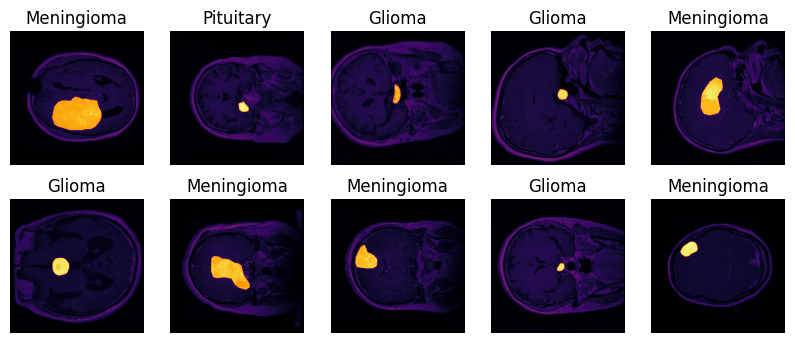

In [13]:
labels = ['Meningioma', 'Glioma', 'Pituitary']
plt.figure(figsize=(10, 4))
for i in range(10):
  index = random.randint(0, len(train_data)-1)
  image, label = train_data[index]
  image = (image*0.5 + 0.5).numpy()
  
  mask = 0.5*image[0,:,:] + image[1,:,:]

  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.title(str(labels[label.item()-1]))
  plt.imshow(mask, cmap='inferno')

## Model and results

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {}'.format(device))

Using cuda


In [24]:
model = models.LowParamCnnWithReLU()
optimizer = optim.Adam(model.parameters(), 0.001)

epochs = 10
low_relu_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.27it/s]



Epoch (1/10): train_loss = 1.058907, val_loss= 0.002607, train_acc = 0.448332, val_acc= 0.557377

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.93it/s]



Epoch (2/10): train_loss = 0.835559, val_loss= 0.001659, train_acc = 0.614543, val_acc= 0.526230

val_loss changed (0.002607 -> 0.001659). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.99it/s]



Epoch (3/10): train_loss = 0.668649, val_loss= 0.001033, train_acc = 0.696009, val_acc= 0.685246

val_loss changed (0.001659 -> 0.001033). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.94it/s]



Epoch (4/10): train_loss = 0.596087, val_loss= 0.000912, train_acc = 0.731547, val_acc= 0.714754

val_loss changed (0.001033 -> 0.000912). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.46it/s]



Epoch (5/10): train_loss = 0.514570, val_loss= 0.001245, train_acc = 0.765446, val_acc= 0.739344



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.98it/s]



Epoch (6/10): train_loss = 0.498980, val_loss= 0.001241, train_acc = 0.770913, val_acc= 0.760656



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.05it/s]



Epoch (7/10): train_loss = 0.474255, val_loss= 0.001028, train_acc = 0.785675, val_acc= 0.757377



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.45it/s]



Epoch (8/10): train_loss = 0.446355, val_loss= 0.002600, train_acc = 0.810279, val_acc= 0.742623



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.91it/s]



Epoch (9/10): train_loss = 0.408360, val_loss= 0.003180, train_acc = 0.819574, val_acc= 0.777049



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.62it/s]


Epoch (10/10): train_loss = 0.419287, val_loss= 0.000258, train_acc = 0.822854, val_acc= 0.808197

val_loss changed (0.000912 -> 0.000258). Saving model...



In [25]:
model = models.LowParamCnnWithSELU()
optimizer = optim.Adam(model.parameters(), 0.001)

epochs = 10
low_selu_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.83it/s]



Epoch (1/10): train_loss = 0.765768, val_loss= 0.001702, train_acc = 0.646802, val_acc= 0.767213

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.39it/s]



Epoch (2/10): train_loss = 0.464423, val_loss= 0.001426, train_acc = 0.794423, val_acc= 0.795082

val_loss changed (0.001702 -> 0.001426). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.80it/s]



Epoch (3/10): train_loss = 0.369170, val_loss= 0.002849, train_acc = 0.840897, val_acc= 0.862295



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  8.00it/s]



Epoch (4/10): train_loss = 0.296492, val_loss= 0.000927, train_acc = 0.879169, val_acc= 0.895082

val_loss changed (0.001426 -> 0.000927). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.96it/s]



Epoch (5/10): train_loss = 0.260950, val_loss= 0.003481, train_acc = 0.890104, val_acc= 0.898361



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.69it/s]



Epoch (6/10): train_loss = 0.209038, val_loss= 0.004222, train_acc = 0.914161, val_acc= 0.913115



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.83it/s]



Epoch (7/10): train_loss = 0.174705, val_loss= 0.003750, train_acc = 0.933844, val_acc= 0.919672



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.56it/s]



Epoch (8/10): train_loss = 0.163807, val_loss= 0.000781, train_acc = 0.935484, val_acc= 0.918033

val_loss changed (0.000927 -> 0.000781). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.66it/s]



Epoch (9/10): train_loss = 0.160953, val_loss= 0.002382, train_acc = 0.940951, val_acc= 0.916393



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.59it/s]


Epoch (10/10): train_loss = 0.108838, val_loss= 0.002381, train_acc = 0.955167, val_acc= 0.918033



In [26]:
model = models.HighParamCnnWithReLU()
optimizer = optim.Adam(model.parameters(), 0.001)

epochs = 10
high_relu_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.09it/s]



Epoch (1/10): train_loss = 0.870781, val_loss= 0.000356, train_acc = 0.560962, val_acc= 0.819672

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.40it/s]



Epoch (2/10): train_loss = 0.438585, val_loss= 0.000311, train_acc = 0.838163, val_acc= 0.824590

val_loss changed (0.000356 -> 0.000311). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.08it/s]



Epoch (3/10): train_loss = 0.390337, val_loss= 0.000055, train_acc = 0.861126, val_acc= 0.868852

val_loss changed (0.000311 -> 0.000055). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.15it/s]



Epoch (4/10): train_loss = 0.271745, val_loss= 0.000149, train_acc = 0.901586, val_acc= 0.932787



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.69it/s]



Epoch (5/10): train_loss = 0.218586, val_loss= 0.000380, train_acc = 0.919628, val_acc= 0.926230



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.47it/s]



Epoch (6/10): train_loss = 0.189099, val_loss= 0.001274, train_acc = 0.940405, val_acc= 0.937705



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.77it/s]



Epoch (7/10): train_loss = 0.195046, val_loss= 0.003447, train_acc = 0.928376, val_acc= 0.931148



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.66it/s]



Epoch (8/10): train_loss = 0.168548, val_loss= 0.000422, train_acc = 0.937124, val_acc= 0.937705



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.91it/s]



Epoch (9/10): train_loss = 0.149786, val_loss= 0.000217, train_acc = 0.949153, val_acc= 0.950820



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.05it/s]


Epoch (10/10): train_loss = 0.126076, val_loss= 0.000447, train_acc = 0.954073, val_acc= 0.950820



In [27]:
model = models.HighParamCnnWithSELU()
optimizer = optim.Adam(model.parameters(), 0.001)

epochs = 10
high_selu_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.12it/s]



Epoch (1/10): train_loss = 0.984743, val_loss= 0.001595, train_acc = 0.578458, val_acc= 0.650820

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.76it/s]



Epoch (2/10): train_loss = 0.590546, val_loss= 0.001269, train_acc = 0.743576, val_acc= 0.808197

val_loss changed (0.001595 -> 0.001269). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.87it/s]



Epoch (3/10): train_loss = 0.477048, val_loss= 0.002392, train_acc = 0.798797, val_acc= 0.819672



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:05<00:00,  3.90it/s]



Epoch (4/10): train_loss = 0.385864, val_loss= 0.001972, train_acc = 0.846364, val_acc= 0.878689



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.80it/s]



Epoch (5/10): train_loss = 0.247830, val_loss= 0.000022, train_acc = 0.902132, val_acc= 0.916393

val_loss changed (0.001269 -> 0.000022). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.27it/s]



Epoch (6/10): train_loss = 0.209659, val_loss= 0.001540, train_acc = 0.913067, val_acc= 0.936066



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.09it/s]



Epoch (7/10): train_loss = 0.202211, val_loss= 0.000381, train_acc = 0.922909, val_acc= 0.914754



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.43it/s]



Epoch (8/10): train_loss = 0.139838, val_loss= 0.001483, train_acc = 0.955167, val_acc= 0.936066



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.35it/s]



Epoch (9/10): train_loss = 0.166836, val_loss= 0.002022, train_acc = 0.935484, val_acc= 0.927869



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.29it/s]


Epoch (10/10): train_loss = 0.166342, val_loss= 0.006382, train_acc = 0.941498, val_acc= 0.909836



<ipython-input-7-10f1849b0732>:60: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


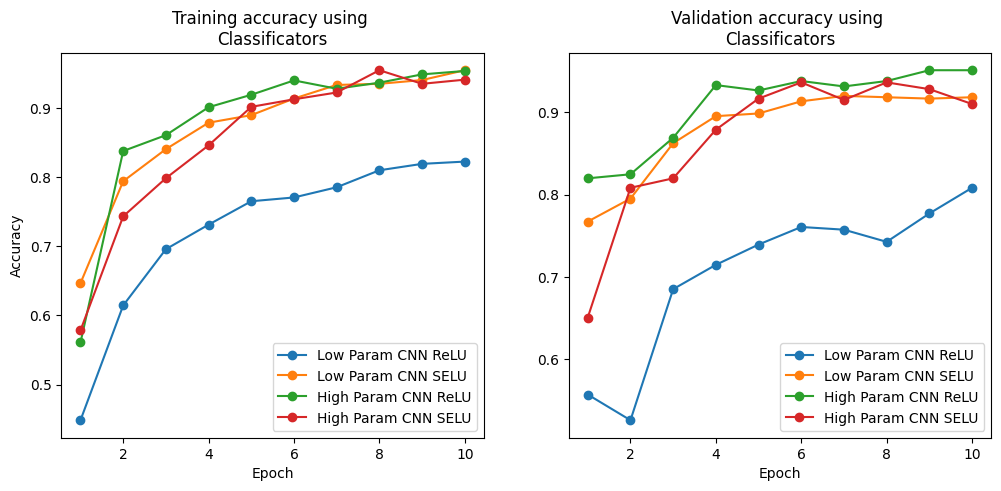

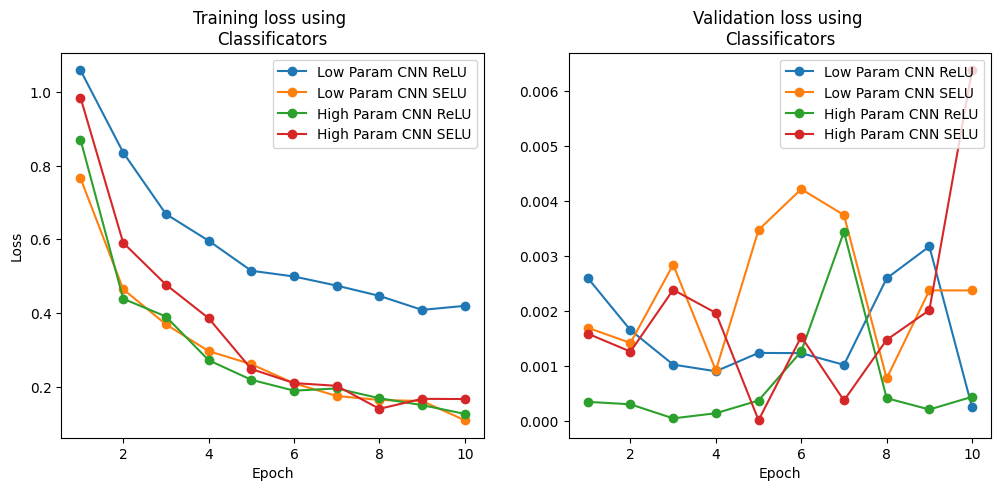

In [28]:
info = {
    'Low Param CNN ReLU': low_relu_dic,
    'Low Param CNN SELU': low_selu_dic,
    'High Param CNN ReLU': high_relu_dic,
    'High Param CNN SELU': high_selu_dic
}

plot_metric_from_array(info, '\nClassificators')
plot_metric_from_array(info, '\nClassificators', metric='loss', legend='upper right')